# Statistical Physics

## Exercise 1.2.6

Import relevant packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import numba as nb
import tqdm.notebook # Progress bar for loops

import ising

%matplotlib inline
# Maybe set seed also

# Ensure to reload the module whenever it is updated
%load_ext autoreload
%autoreload 2

Some description of the Ising model and the Metropolis Hastings algorithm

Define functions used in the code. Move to .py file soon

In [2]:
# Initial state, randomly draws either -1 or +1 on a NxN array. N is the row/column length of the lattice
def initialstate(N):
    
    '''Generates a random spin configuration for initial condition'''
    
    state = 2*np.random.randint(2, size=(N,N)) - 1
    
    return state

# Monte Carlo move using Metropolis-Hastings
@nb.njit
def mcmove(config, beta, J=1, h=0):
    
    '''Monte Carlo move using the Metropolis-Hastings algorithm '''

    # Perform N^2 iterations, corresponding to one Monte Carlo update
    for _ in range(N*N):
                
            # Draw a random site, by drawing random row and column number
            i,j = np.random.randint(0,N), np.random.randint(0,N)

            # Define the lattice site chosen
            s =  config[i, j]

            # Compute energy of current configuration
            E_stay = -J*s*(config[(i + 1)%N, j] + config[i, (j + 1)%N] + config[(i - 1)%N, j] + config[i, (j - 1)%N]) - h*s

            # Energy when flipping the spin is just minus the current energy
            E_flip = - E_stay

            # Determine whether to flip the spin or not using Metropolis-Hastings
            if np.random.rand() < np.exp(-beta*(E_flip - E_stay)) :
                s *= -1

            # Save the move of the lattice site 
            config[i,j] = s
                
    return config

# Calculate energy of lattice configuration
@nb.njit
def calcEnergy(config, J=1, h=0):
    '''Average energy of a given configuration'''
    
    # Initialize
    energy = 0
    
    # Loop over all sites
    for i in range(len(config)):
        for j in range(len(config)):
            
            s = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            
            # Energy is from the Hamiltonian. Divide by 4 to avoid double counting (each site has 4 neighbours)
            energy += (-J*nb*s / 4.0 - h*s) / (N*N)
            
    return energy

# Magnetization
@nb.njit
def calcMag(config):
    '''Magnetization per site of a given configuration'''
    
    # Average magnetization is simply the sum of all spins in the lattice divided by # of elements
    mag = np.sum(config)/(N*N)
    return mag

Define parameter values

In [2]:
N = 20
n_max = 30000
n_0 = 2000
J = 1.0
h = 0.0
beta = 1 / 2.27
# Define additional params here...

Create and plot and initial state for visualization

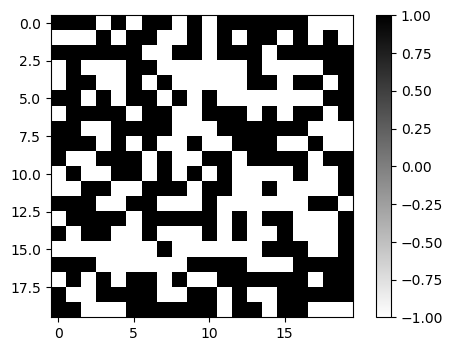

In [4]:
# Define initial state
config = ising.initialstate(N)

# Test plot
plt.figure(dpi=100)
plt.imshow(config, cmap='binary')
plt.colorbar()

In [20]:
np.shape(config)[1]

20

Run the Metroplis-Hastings algorithm for the Ising model.
For each Monte Carlo step, I save the resulting average energy and magnetization per site.

In [12]:
# Initialize
config = initialstate(N)
energy_vec = np.empty(n_max)
mag_vec = np.empty(n_max)

# Perform n_max Monte Carlo steps
for i in range(n_max) :
    
    # Energy per site and average magnetization
    energy_vec[i] = calcEnergy(config, J, h)
    mag_vec[i] = calcMag(config)
    
    # Perform MC move
    mcmove(config, beta, J, h)

Plot the resulting lattice

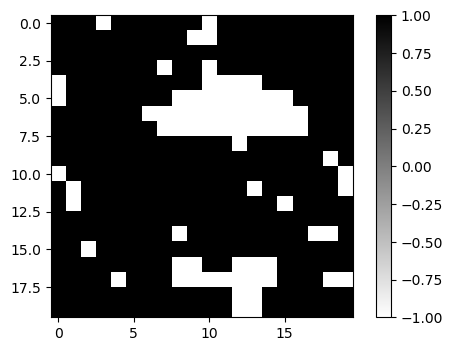

In [13]:
plt.figure(dpi=100)
plt.imshow(config, cmap='binary')
plt.colorbar()
plt.show()

Plot average energy and magnetization is a function of the iteration number

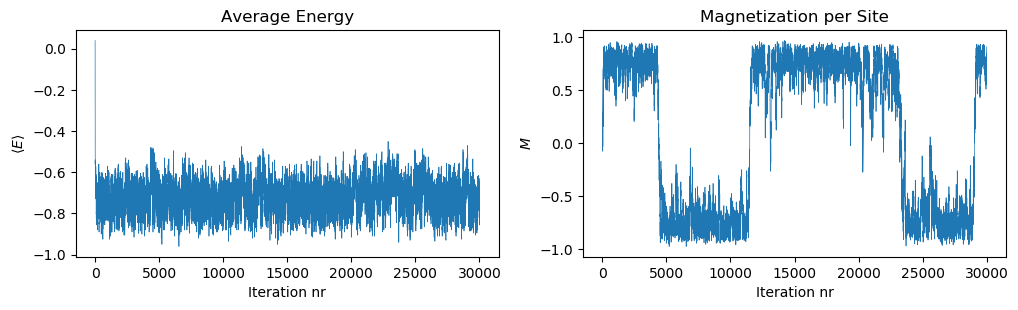

In [7]:
# Initialize figure
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,3),dpi=100)

# Energy 
ax1.plot(energy_vec, linewidth = 0.5)
ax1.set_title('Average Energy')
ax1.set_xlabel('Iteration nr')
ax1.set_ylabel('$\\langle E \\rangle$')

# Magnetization
ax2.plot(mag_vec, linewidth = 0.5)
ax2.set_title('Magnetization per Site')
ax2.set_ylabel('$M$')
ax2.set_xlabel('Iteration nr')

plt.show()

Compute internal energy $\langle E \rangle$ and magnetization per site $\langle s \rangle$ as a function of $k_B T = \beta^{-1}$.

In [8]:
################
## Initialize ##
################

kbT_vec = np.linspace(0.5, 3.5, 50) # Vector of values of inverse beta
energy_vec_kbT = np.empty(len(kbT_vec))
mag_vec_kbT = np.empty(len(kbT_vec))

#####################
## Run Monte Carlo ##
#####################

for i,kbT in enumerate(kbT_vec):
    
    # Initialize
    config = initialstate(N)
    E_temp = np.empty(n_max - n_0)
    mag_temp = np.empty(n_max - n_0)
    
    # Beta is the inverse temperature
    beta_val = 1/kbT
    
    # run MC-MC
    for it in range(n_max):
        if it > n_0:
            
            mcmove(config, beta_val, J, h)

            E_temp[it - n_0] = calcEnergy(config, J, h)
            mag_temp[it - n_0] = calcMag(config)
    
    energy_vec_kbT[i] = np.mean(E_temp)
    mag_vec_kbT[i] = np.mean(np.abs(mag_temp)) # Calculate the absolute magnetization as the solution is symmetric

Plot the results

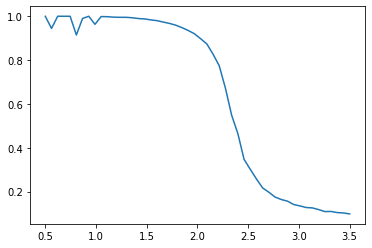

In [9]:
plt.plot(kbT_vec, mag_vec_kbT)

Check this out...

In [78]:
# beta_vec = np.linspace()

################
## Initialize ##
################

n0_vec = np.arange(100, 2500, 100) # Change nr of steps
energy_vec = np.zeros(len(n0_vec))
mag_vec = np.zeros(len(n0_vec))

#####################
## Run Monte Carlo ##
#####################

for i,n0 in enumerate(n0_vec) :
    
    # Initial distribution
    config = initialstate(N)

    # Run Monte Carlo and store vals after n0 iterations
    for it in range(n_max) :
        
        mcmove(config, beta, J, h)
        
        if it > n0 :
            
            # Compute energy and magnetization
            energy_vec[i] += (calcEnergy(config, J, h) / (N*N)) / (n_max-n0)
            mag_vec[i] += calcMag(config) / (n_max-n0)
    
    
    
    
    
    
    
    
# # Energy
# print(calcEnergy(config,J,h)/N**2)
# print(calcMag(config))


In [50]:
n0_vec = np.arange(100, 1000, 100) # Change nr of steps
len(n0_vec)

9

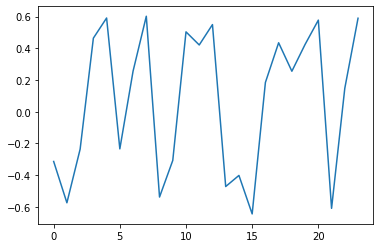

In [126]:
plt.plot(mag_vec/(N*N))